# Autonomous Inventory Monitoring at Distribution Centers
This notebook first downloads a subset of the Amazon Bin Image Dataset, then divides them into train, validation and test sets. The data is then uploaded to S3 for training. The notebook then explores the dataset and trains machine learning models to classify each image into one of five categories (1 - 5 items). This notebook also does hyperparameter tuning and utilizes debugger hook to achieve better results.

In [2]:
# TODO: Install any packages that you might need
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [1]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
import os
import pandas
import json
import torch
import torchvision
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from sagemaker.pytorch import PyTorch

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [10]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:33<00:00, 13.19it/s]


100%|██████████| 2299/2299 [03:01<00:00, 12.70it/s]


100%|██████████| 2666/2666 [03:33<00:00, 12.51it/s]


100%|██████████| 2373/2373 [03:03<00:00, 12.92it/s]


100%|██████████| 1875/1875 [02:22<00:00, 13.18it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [3]:
with open('file_list.json', 'r') as f:
    d=json.load(f)

In [4]:
for key in d.keys():
    print(len(d[key]))

1228
2299
2666
2373
1875


In [5]:
total_count = np.sum([len(d[key]) for key in d.keys()])
print(total_count)

10441


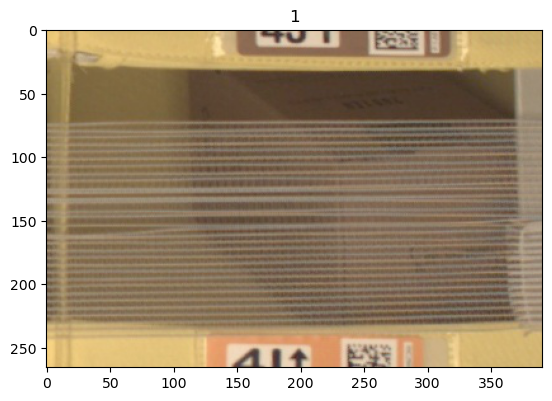

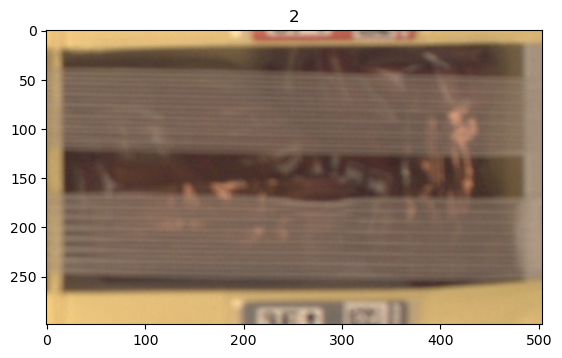

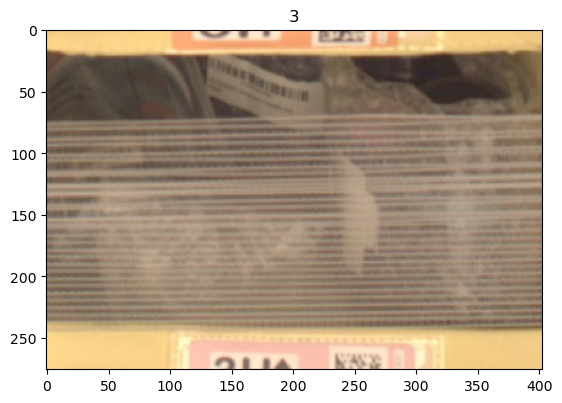

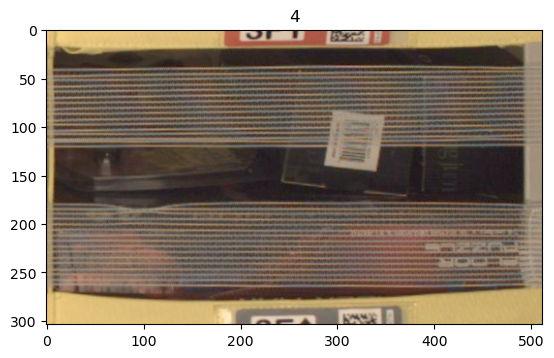

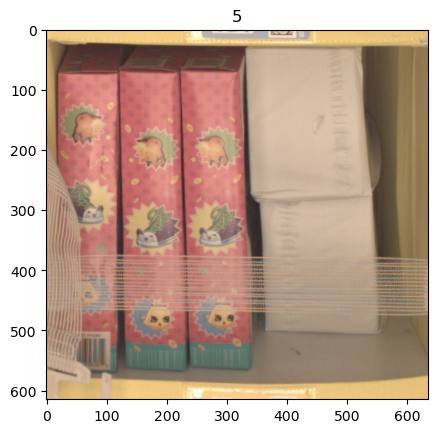

In [6]:
for i in range(1, 6):
    filename = random.choice(os.listdir(f"train_data/{i}"))
    img = mpimg.imread(f"train_data/{i}/{filename}")
    plt.figure()
    plt.imshow(img)
    plt.title(f"{i}")

In [30]:
shape_array = np.zeros((total_count, 2))
idx = 0
for root, dirs, files in os.walk("train_data"):
    for name in files:
        img = mpimg.imread(os.path.join(root, name))
        shape_array[idx, 0] = img.shape[0]
        shape_array[idx, 1] = img.shape[1]
        idx += 1

Text(0.5, 1.0, 'hist of image sizes')

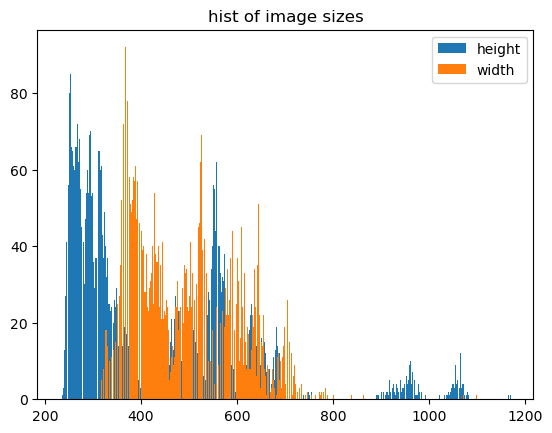

In [34]:
hist = plt.hist(shape_array[:, 0], bins=1000, label='height')
hist = plt.hist(shape_array[:, 1], bins=1000, label='width')
plt.legend()
plt.title('hist of image sizes')

In [35]:
avg_height = np.mean(shape_array[:, 0])
avg_width = np.mean(shape_array[:, 1])
print(avg_height, avg_width)I 

432.04712192318743 485.8979982760272


In [10]:
RGB_array = np.zeros((3, 224*1000*224))
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.ToTensor()])
test_loader = create_data_loaders('data/test', 1000, data_transform)
data_iter = iter(test_loader)
data, label = next(data_iter)
for i in range(len(data)):
    img = data[i]
    for j in range(3):
        RGB_array[j][i*224*224:(i+1)*224*224] = img[j].flatten()

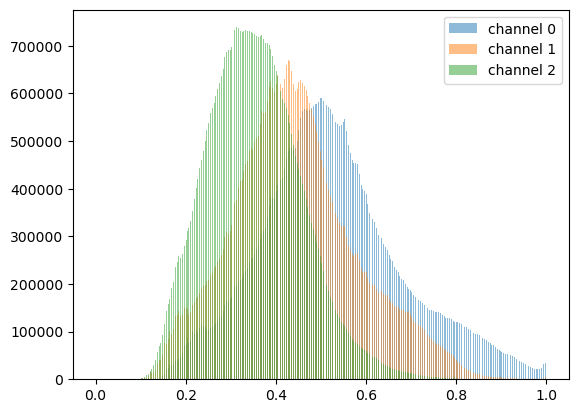

In [11]:
plt.figure()
for i in range(3):
    plt.hist(RGB_array[i], label=f'channel {i}', bins=500, alpha=0.5)
    plt.legend()

In [14]:
for i in range(3):
    print(f'channel {i} mean: {RGB_array[i].mean()}, std: {RGB_array[i].std()}')

channel 0 mean: 0.5248156155393444, std: 0.15855359884222653
channel 1 mean: 0.4430371637265768, std: 0.13905828669049872
channel 2 mean: 0.3532477724078742, std: 0.10488192816795312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

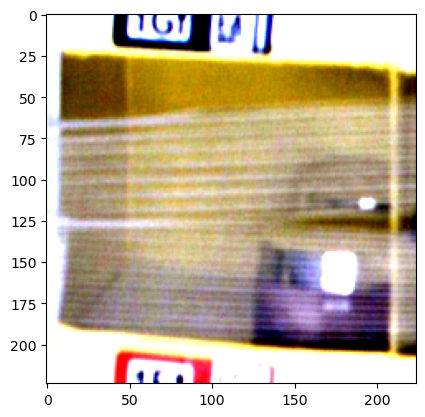

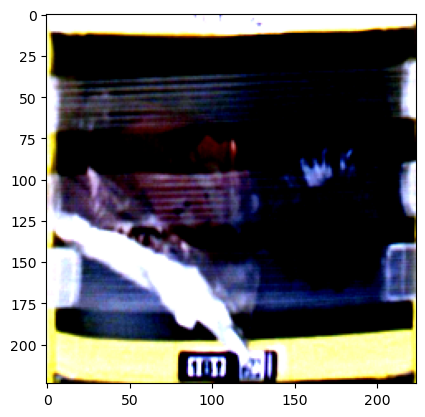

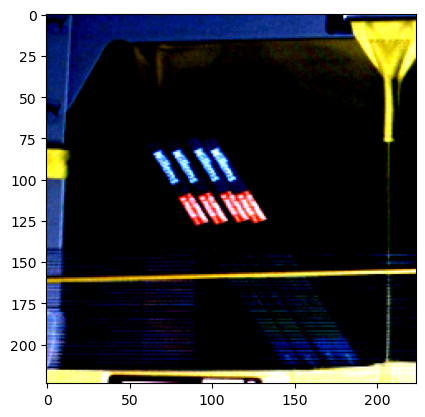

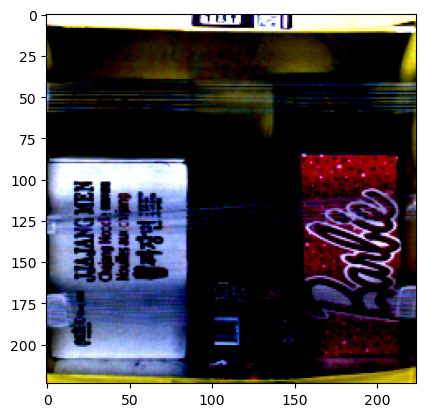

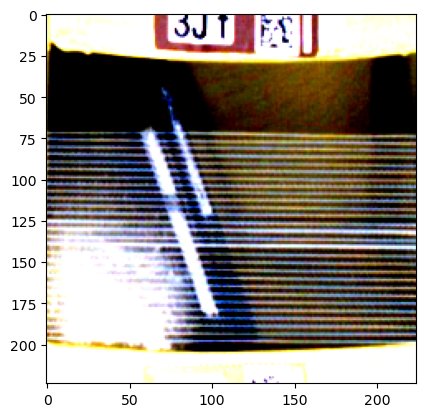

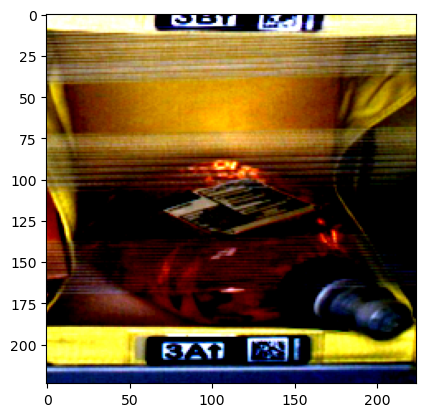

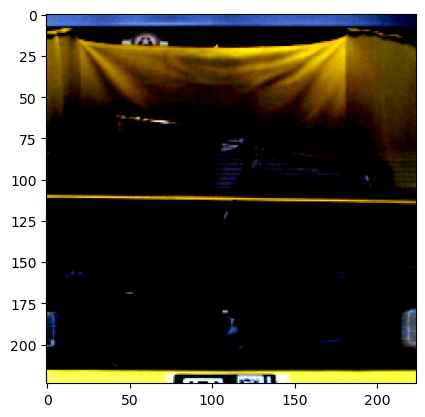

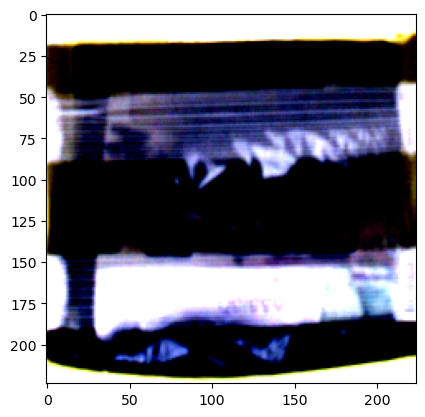

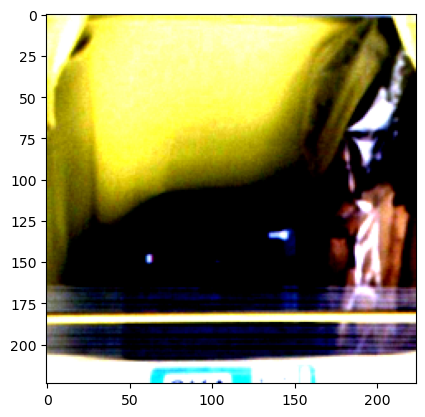

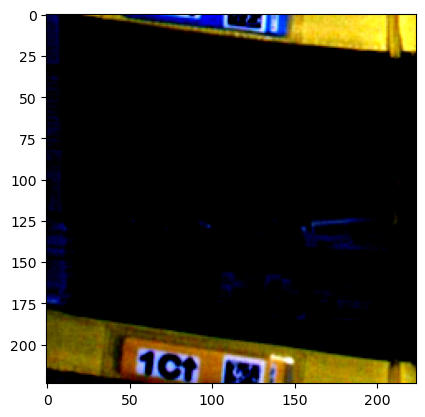

In [15]:
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize((0.52, 0.44, 0.35), (0.15, 0.14, 0.105))])
test_loader = create_data_loaders('data/test', 10, data_transform)
data_iter = iter(test_loader)
data, label = next(data_iter)
for img in data:
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))

In [39]:
#TODO: Perform any data cleaning or data preprocessing
# separate data into train, validation and test set
import splitfolders
splitfolders.ratio('train_data', output="data", seed=1337, ratio=(.8, 0.1, 0.1)) 

Copying files: 10441 files [00:04, 2360.07 files/s]


In [16]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [41]:
#TODO: Upload the data to AWS S3
role = sagemaker.get_execution_role()
# upload data to S3
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix="data")

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [17]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters = {'lr': 0.0001,
                  'batch_size': 64,
                   'epochs': 10}

In [18]:
#TODO: Create your training estimator
estimator = PyTorch(hyperparameters=hyperparameters,
                   entry_point='train.py',
                   py_version='py36',
                    instance_type='ml.p2.xlarge',
                    instance_count=1,
                    framework_version='1.8',
                    role=sagemaker.get_execution_role()
                   )

In [20]:
# TODO: Fit your estimator
# new normalization
estimator.fit({'train': data_path+'train', 'val': data_path+'val', 'test': data_path+'test'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-04-05-33-49-415


2023-04-04 05:33:50 Starting - Starting the training job...
2023-04-04 05:34:19 Starting - Preparing the instances for training.........
2023-04-04 05:35:29 Downloading - Downloading input data...
2023-04-04 05:36:19 Training - Downloading the training image...........................
2023-04-04 05:40:31 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-04 05:41:05,748 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-04 05:41:05,772 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-04 05:41:05,775 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-04 05:41:06,037 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": 

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [21]:
#TODO: Create your hyperparameter search space
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.001, scaling_type='ReverseLogarithmic'),
    "batch_size": CategoricalParameter([64, 128]),
    "model_type": CategoricalParameter(['ResNet18', 'ResNet34'])
}

In [22]:
#TODO: Create your training estimator
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test loss: ([0-9\\.]+)"}]

estimator = PyTorch(entry_point='train.py',
                   py_version='py36',
                    instance_type='ml.p2.xlarge',
                    instance_count=1,
                    framework_version='1.8',
                    role=sagemaker.get_execution_role()
                   )

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=6,
    max_parallel_jobs=1,
    objective_type=objective_type)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [23]:
# TODO: Fit your estimator
tuner.fit({'train': data_path+'train', 'val': data_path+'val', 'test': data_path+'test'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-230404-0624


.............................................................................................................................................................................................................................................................

KeyboardInterrupt: 

In [4]:
# TODO: Find the best hyperparameters
tuner = sagemaker.HyperparameterTuningJobAnalytics('pytorch-training-230404-0624')

full_df = tuner.dataframe()
full_df.to_csv('pytorch-training-230404-0624.csv')

In [23]:
full_df

,batch_size,lr,model_type,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""128""",0.000122,"""ResNet18""",pytorch-training-230404-0624-006-a862d321,Completed,1.5279,2023-04-04 07:23:35+00:00,2023-04-04 07:32:18+00:00,523.0
1,"""64""",0.000880,"""ResNet34""",pytorch-training-230404-0624-005-60cf9c55,Completed,1.4972,2023-04-04 07:13:12+00:00,2023-04-04 07:22:56+00:00,584.0
2,"""128""",0.000547,"""ResNet18""",pytorch-training-230404-0624-004-7c45944f,Completed,1.4628,2023-04-04 07:03:01+00:00,2023-04-04 07:11:50+00:00,529.0
3,"""64""",0.000634,"""ResNet34""",pytorch-training-230404-0624-003-1f6dd2b6,Completed,1.4852,2023-04-04 06:51:48+00:00,2023-04-04 07:01:27+00:00,579.0
4,"""64""",0.000163,"""ResNet18""",pytorch-training-230404-0624-002-96b39f35,Completed,1.4941,2023-04-04 06:41:30+00:00,2023-04-04 06:50:19+00:00,529.0
5,"""128""",0.000767,"""ResNet34""",pytorch-training-230404-0624-001-72b52884,Completed,1.4914,2023-04-04 06:26:06+00:00,2023-04-04 06:40:41+00:00,875.0


In [8]:
best_training_job_name = 'pytorch-training-230404-0624-004-7c45944f'
best_estimator = sagemaker.estimator.Estimator.attach(best_training_job_name)


2023-04-04 07:13:10 Starting - Found matching resource for reuse
2023-04-04 07:13:10 Downloading - Downloading input data
2023-04-04 07:13:10 Training - Training image download completed. Training in progress.
2023-04-04 07:13:10 Uploading - Uploading generated training model
2023-04-04 07:13:10 Completed - Resource reused by training job: pytorch-training-230404-0624-005-60cf9c55


### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [37]:
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 25.0 MB/s eta 0:00:00


In [38]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import DebuggerHookConfig, CollectionConfig
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

[2023-04-04 22:27:00.977 ip-172-16-69-212.ec2.internal:7095 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [ ]:
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"},
    collection_configs=[CollectionConfig(name='custom_collection',
                                        parameters={'include_regex': "CrossEntropyLoss_output_0"})]
)

In [32]:
# TODO: Create and fit an estimator
best_hyperparameters = full_df[full_df['TrainingJobName'] == best_training_job_name].squeeze()
hyperparameters = {
    'lr': best_hyperparameters['lr'],
    'model_type': best_hyperparameters['model_type'][1:-1],
    'batch_size': int(best_hyperparameters['batch_size'][1:-1]),
    'epochs': 15
}
print(hyperparameters)

estimator = PyTorch(hyperparameters=hyperparameters,
                   entry_point='train.py',
                   py_version='py36',
                    instance_type='ml.p2.xlarge',
                    instance_count=1,
                    framework_version='1.8',
                    role=sagemaker.get_execution_role(),
                    debugger_hook_config=debugger_config
                   )

data_path = 's3://sagemaker-us-east-1-643509438179/data/'


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


{'lr': 0.0005473208759755705, 'model_type': 'ResNet18', 'batch_size': 128, 'epochs': 15}


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [34]:
estimator.fit({'train': data_path+'train', 'val': data_path+'val', 'test': data_path+'test'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-04-04-17-43-34-786


2023-04-04 17:43:35 Starting - Starting the training job......
2023-04-04 17:44:14 Starting - Preparing the instances for training......
2023-04-04 17:45:31 Downloading - Downloading input data......
2023-04-04 17:46:26 Training - Downloading the training image........................
2023-04-04 17:50:28 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-04 17:50:57,679 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-04 17:50:57,701 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-04 17:50:57,704 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-04 17:50:57,996 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test":

In [39]:
# TODO: Plot a debugging output.
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2023-04-04 22:27:09.002 ip-172-16-69-212.ec2.internal:7095 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-643509438179/pytorch-training-2023-04-04-17-43-34-786/debug-output


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[2023-04-04 22:27:10.440 ip-172-16-69-212.ec2.internal:7095 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-04-04 22:27:11.459 ip-172-16-69-212.ec2.internal:7095 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0']

In [40]:
tensor_name = 'CrossEntropyLoss_output_0'
trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN)
# trial.tensor(tensor_name).value(step, mode=ModeKeys.TRAIN)

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

In [41]:
training_loss_list = []
for step in trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN):
    training_loss_list.append(trial.tensor(tensor_name).value(step, mode=ModeKeys.TRAIN))

In [43]:
val_loss_list = []
for step in trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL):
    val_loss_list.append(trial.tensor(tensor_name).value(step, mode=ModeKeys.EVAL))

Text(0.5, 1.0, 'Training loss')

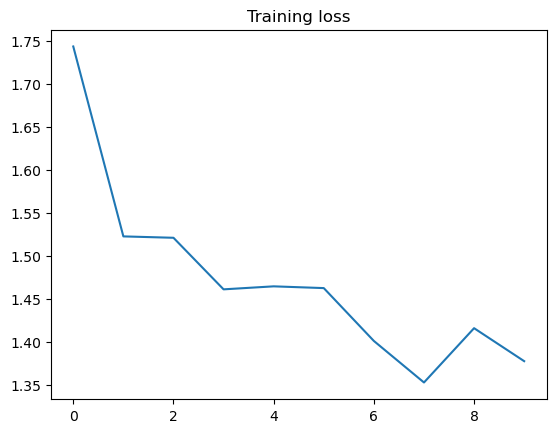

In [45]:
plt.plot(training_loss_list)
plt.title('Training loss')

Text(0.5, 1.0, 'Validation loss')

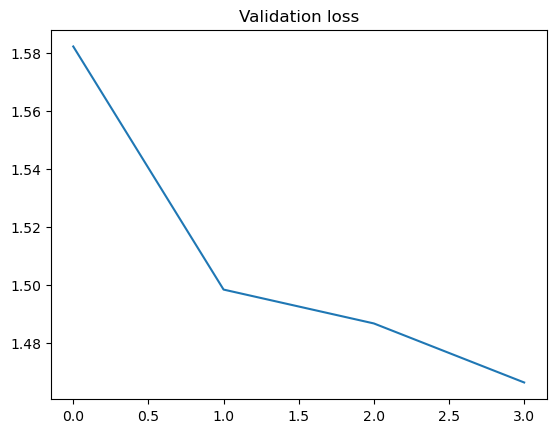

In [46]:
plt.plot(val_loss_list)
plt.title('Validation loss')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances